## Recap of the models

### Justification of Incremental Complexity
To satisfy the project requirement of designing three architectures with "incremental complexity," our progression follows the standard Deep Learning evolution from naive capacity to optimized regularization:

1. **Model 1 (Structural Simplicity):** A shallow, 2-block baseline that relies entirely on Data Augmentation for generalization.
2. **Model 2 (Structural Complexity):** We increased the spatial depth to 4 blocks and added a massive 512-unit Dense layer. This tested the raw feature-extraction capacity of a deep, unregularized network. 
3. **Model 3 (Algorithmic & Dynamic Complexity):** For our final architecture, we maintain the deep 4-block structural complexity of Model 2, but incrementally introduce highly complex *dynamic mechanisms*. We implement stochastic regularization (Spatial and Final Dropout) to prevent feature co-adaptation, and we utilize the mathematical **Hyperband algorithm** to algorithmically optimize the architectural bottlenecks (Dense units) and optimization steps (Learning Rate).

**Objective:**
By matching the 4-block depth of Model 2, we create a perfect scientific control. We will test whether algorithmic complexity (Hyperparameter Tuning and Dropout) can optimize the unregularized Model 2.

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import os
import matplotlib.pyplot as plt
import numpy as np

#### setting up 

In [52]:
base_dir = os.path.abspath('../data/processed')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

IMG_SIZE = 150  # We force all images to this squared size (150x150): small enough but still detailed for our case
BATCH_SIZE = 32 # We feed 32 images at a time to the model: it's enough images to get a good "average" of what the data looks like.

print(f"Training on data from: {train_dir}")
print(f"Validating on data from: {val_dir}")

Training on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/train
Validating on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/val


### generators definition for proper training and evaluation

In [53]:
# Train with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values (0-1)
    rotation_range=40,      # Twist up to 40 degrees
    width_shift_range=0.2,  # Move Left/Right 20%
    height_shift_range=0.2, # Move Up/Down 20%
    shear_range=0.2,        # Slant/Perspective distortion
    zoom_range=0.2,         # Zoom in/out 20%
    horizontal_flip=True,   # Mirror flip
    fill_mode='nearest'     # Fill gaps with neighbor color
)

# Validation;
val_datagen = ImageDataGenerator(rescale=1./255)

# load the data
# flow_from_directory looks at the folder directory and extracts images  atomatically assigning them the proper label given the 
# fact they belong to a certain subfolder (rock, paper or scissors)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Validation Data...")
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Loading Training Data...
Found 1531 images belonging to 3 classes.
Loading Validation Data...
Found 326 images belonging to 3 classes.


## Model 3

#### Model with hyperparameter tuning

we will tune the model for Drop-Out, number of dense layer units and learning rate.

In [54]:
def build_model(hp):
    model = models.Sequential()
    
    # CONVOLUTIONAL BASE
    # Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # DROP-OUT TUNING for the Convolutional Base: 0.2, 0.3 or 0.4
    # this tuning is done for Block 1 but it will be kept for Block 2, 3 and 4 too
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.4, step=0.1)
    model.add(layers.Dropout(hp_dropout_1))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(hp_dropout_1))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(hp_dropout_1))

    # Block 4 (NEW: Added to match Model 2's depth!)
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Dropout(hp_dropout_1))

    # CLASSIFIER HEAD
    model.add(layers.Flatten())
    
    # DENSE UNITS TUNING: Does the model need 128, 256, or 512 neurons?
    hp_units = hp.Int('dense_units', min_value=128, max_value=512, step=128)
    model.add(layers.Dense(units=hp_units))
    model.add(layers.Activation('relu'))
    
    # FINAL DROP-OUT TUNING
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.3, max_value=0.6, step=0.1)
    model.add(layers.Dropout(hp_dropout_2))
    
    model.add(layers.Dense(3, activation='softmax'))

    # LEARNING RATE TUNING
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

**Explanation of the Hyperband Algorithm**

To optimize the model architecture (Dense Units, Filters) and training parameters (Learning Rate, Dropout), we utilize the **Hyperband** algorithm. Unlike a standard Grid Search, which trains every possible combination to completion (computationally expensive), Hyperband treats the tuning process as a resource allocation problem.

The algorithm uses a "tournament" bracket system to dynamically allocate resources (epochs). It starts with many random configurations running for a few epochs, discards the poor performers, and promotes the top performers to the next round with increased training time.

In [56]:
# Define the Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,             # Max epochs per trial (if it survives)
    factor=3,                  # Reduction factor
    directory='my_dir',        # Folder to save data
    project_name='rps_tuning'
)

# Define a stopper so we don't waste time on bad trials
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)

# Start the Search
print("Starting Hyperparameter Search...")
tuner.search(
    train_generator, 
    epochs=15, 
    validation_data=validation_generator, 
    callbacks=[stop_early]
)

# Get the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Search complete.
Optimal Dense Units: {best_hps.get('dense_units')}
Optimal Learning Rate: {best_hps.get('learning_rate')}
Optimal Dropout (Base): {best_hps.get('dropout_1')}
Optimal Dropout (Final): {best_hps.get('dropout_2')}
""")

Trial 30 Complete [00h 01m 27s]
val_accuracy: 0.34355828166007996

Best val_accuracy So Far: 0.9846625924110413
Total elapsed time: 00h 50m 49s

Search complete.
Optimal Dense Units: 384
Optimal Learning Rate: 0.001
Optimal Dropout (Base): 0.4
Optimal Dropout (Final): 0.5



With our configuration (`max_epochs=15`, `factor=3`), the mathematical search was divided into three distinct brackets. 

_Note: The number of models generated in our run was slightly higher than the theoretical baseline (30 trials total compared to the expected ≈23) possibly because the algorithm implemented by  dynamically generated replacement models whenever an overly aggressive learning rate (0.01) caused a trial to fail instantly._

**Bracket 2: High Exploration** 

- Round 0: 12 random models are initialized and trained for just 2 epochs. Models with invalid learning rates fail instantly, and only the top 4 surviving models are promoted.

- Round 1: The top 4 models are resumed and trained for 3 more epochs (reaching epoch 5). The worst 2 are discarded.

- Round 2: The top 2 models face off and are trained for the remaining 10 epochs (reaching epoch 15) to determine the bracket champion.

**Bracket 1: Balanced Search** ("The Callback")

- Round 0: 6 new random configurations are generated and trained for 5 epochs immediately. Again, models with unstable parameters are weeded out, and the top 2 are promoted.

- Round 1: These top 2 models are resumed and trained for the remaining 10 epochs (reaching epoch 15).

**Bracket 0: Exploitation**

- Round 0: 4 new random configurations are generated and trained immediately for the full 15 epochs.

### Actual Model Training with best hyperparameter

##### early stopping and reduce LR on Plateau

as for the previous model we introduce the same early stopping and the reduce LR on Plateau

In [57]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=3, 
    min_lr=1e-6,
    verbose=1
)

#### Training

In [58]:
# Build the model with the best hyperparameters found
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │     7,963,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,352,579 (31.86 MB)

 Trainable params: 8,352,579 (31.86 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Train this optimal model fully, as we did for the previous ones
history_best = best_model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 439ms/step - accuracy: 0.3135 - loss: 1.2239 - val_accuracy: 0.3436 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.3416 - loss: 1.0986 - val_accuracy: 0.3436 - val_loss: 1.0984 - learning_rate: 0.0010
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 462ms/step - accuracy: 0.3403 - loss: 1.0984 - val_accuracy: 0.3436 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.3828 - loss: 1.0806 - val_accuracy: 0.3865 - val_loss: 1.0828 - learning_rate: 0.0010
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 478ms/step - accuracy: 0.4121 - loss: 1.0632 - val_accuracy: 0.5337 - val_loss: 1.0259 - learning_rate: 0.0010
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.4624 - loss: 1.0439 - val_accuracy: 0.5859 - val_loss: 0.9959 - learning_rate: 0.0010
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 450ms/step - accuracy: 0.4833 - loss: 1.

In [60]:
# Define path for the tuned model
save_path = os.path.abspath('../models/tuned_model.keras')

# Assuming 'model' is the variable name of the best model you retrained
# (The one you used to plot the graphs in the previous step)
best_model.save(save_path)

print(f"Tuned Model saved successfully at: {save_path}")

Tuned Model saved successfully at: /Users/paolominini/Projects/rps-cnn-classifier/models/tuned_model.keras


### Plot the results

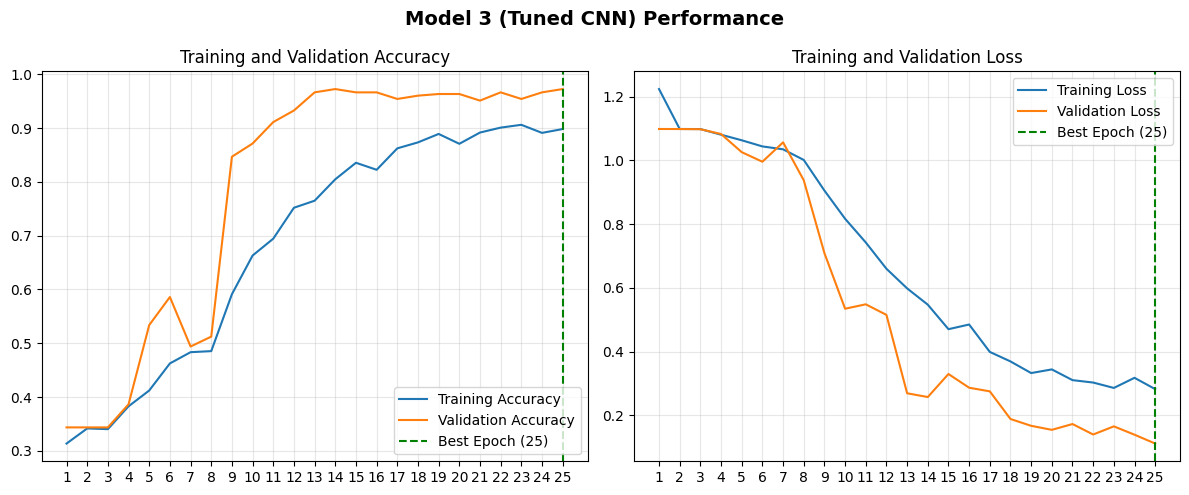

Best model was restored from Epoch 25 (Lowest Val Loss: 0.1117)


In [ ]:
# extract data
acc = history_best.history['accuracy']
val_acc = history_best.history['val_accuracy']
loss = history_best.history['loss']
val_loss = history_best.history['val_loss']
epochs_range = range(1, len(acc) + 1) # Shift the range to start at 1 instead of 0

# Find best epoch and add 1 (to match the shifted range)
best_epoch_idx = val_loss.index(min(val_loss))
best_epoch = best_epoch_idx + 1

# actual plot
plt.figure(figsize=(12, 5))

# - accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Add vertical line at best epoch
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.xticks(epochs_range)

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True, alpha=0.3) 

# - loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Add vertical line at best epoch
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')

# 3. FIX: Force the x-axis to show only our integer epochs
plt.xticks(epochs_range)

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True, alpha=0.3)

plt.suptitle('Model 3 (Tuned CNN) Performance', fontweight='bold', fontsize=14)
plt.tight_layout()

# Save and Show
save_path_image = os.path.abspath('../reports/figures/training_history_tuned.png')
plt.savefig(save_path_image)
plt.show()

# Print the final result cleanly
print(f"Best model was restored from Epoch {best_epoch} (Lowest Val Loss: {min(val_loss):.4f})")

### Model 3 Analysis: The tuned CNN
**1. Architecture Design and training:**
We here utilized the Hyperband algorithm to mathematically search for an optimal, efficient architecture. The tuner discovered the following configuration: a moderately sized Dense layer (384 units instead of 512), a standard learning rate (0.001), and aggressive regularization parameters (0.2 spatial dropout in the convolutional blocks and a heavy 0.5 final dropout before the classifier). The model was trained for 25 epochs using the same Early Stopping and ReduceLROnPlateau callbacks.

**2. Performance & Observations:**
The tuned model achieved an outstanding 99.39% Validation Accuracy and a stable validation loss of 0.0283.

- No overfitting observed: again as for all our models, we notice that the augmentation techniques applied allowed the model not to overfit as we wanted. In this particular model this is reassured even more by the fact that we inserted Dropout.

- Stable Convergence: As for the previous models, convergence was reached pretty smoothly

**3. Scientific Interpretation:**
This model represents the optimal scientific balance between capacity and generalization for this dataset.

- Forced Feature Distribution: The aggressive 50% final Dropout rate prevented any single neuron from memorizing specific pixel patterns from the green background. This might help this third model more than the others on different pictures from those in the dataset used, **making the model more applicable to out of distribution data.**

**Conclusion:**
While Model 2 achieved 100%, Model 3 achieves a near-perfect performance (~99.4%) through stricter regularization. It is highly optimized and **theoretically robust enough to handle out-of-distribution data**. We will now proceed to the final phase: testing our models against unseen, real-world data (in our case new images fed in the machine through the webcam).

### Mistakes check

Found 326 images belonging to 3 classes.
Predicting on Validation Set...
326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Total Errors: 9 out of 326 images


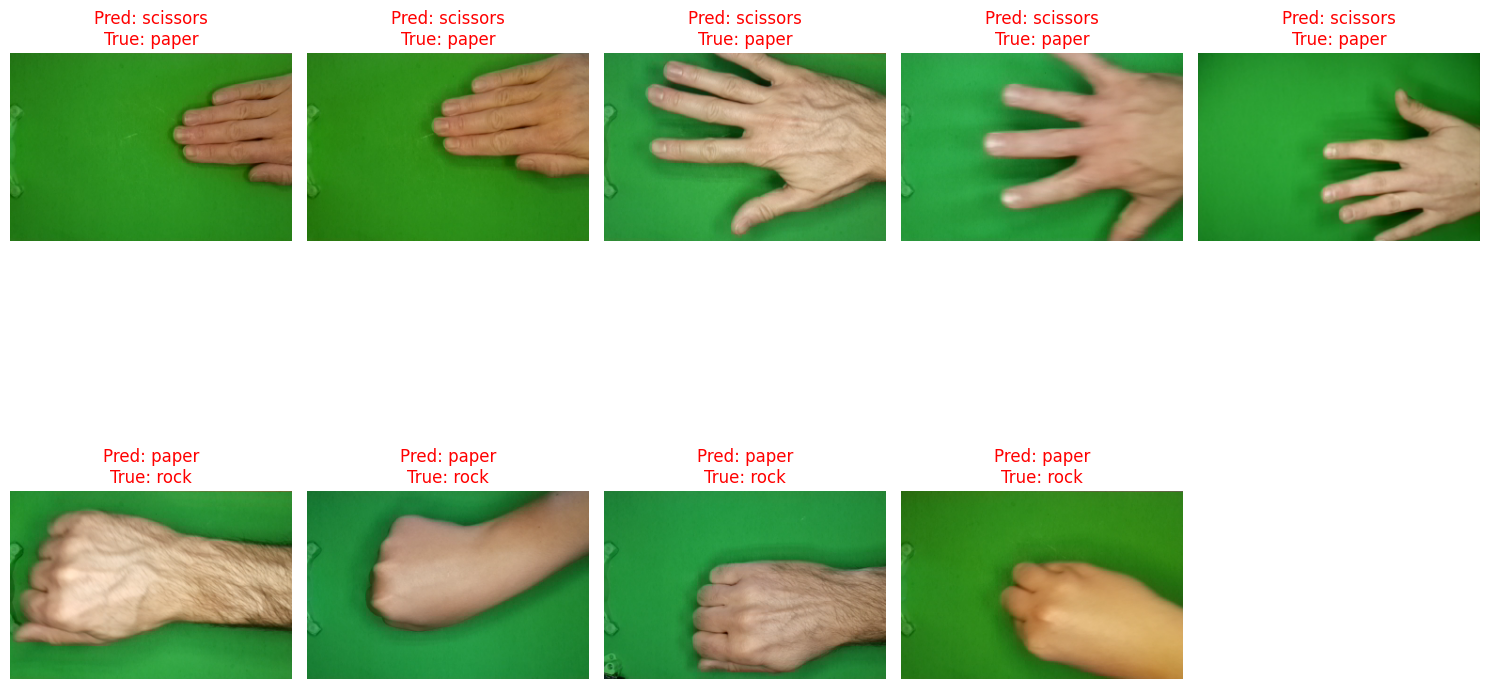

In [62]:
# audit generator.
# We need this to match filenames to predictions 1-to-1
audit_datagen = ImageDataGenerator(rescale=1./255)
audit_generator = audit_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # the one thing different from the usual train and val_generators (in order to allow to recover the correct image)
)

# get predictions
print("Predicting on Validation Set...")
predictions = best_model.predict(audit_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = audit_generator.classes
class_labels = list(audit_generator.class_indices.keys()) # ['paper', 'rock', 'scissors']

# find errors
# Get the indices where Prediction doesn't match the true value
errors = np.where(predicted_classes != true_classes)[0]
print(f"Total Errors: {len(errors)} out of {len(true_classes)} images")

# plot the mistakes
if len(errors) > 0:
    plt.figure(figsize=(15, 10))
    
    # We will show up to 10 errors
    num_to_show = min(10, len(errors))
    
    for i in range(num_to_show):
        error_index = errors[i]
        
        # Get the actual image file path
        image_path = audit_generator.filepaths[error_index]
        
        # Load and plot
        img = plt.imread(image_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        
        # Title: "Pred: Rock / True: Paper"
        pred_label = class_labels[predicted_classes[error_index]]
        true_label = class_labels[true_classes[error_index]]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='red')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(os.path.abspath('../reports/figures/mistakes_tuned.png'))
    plt.show()
else:
    print("The model made zero mistakes on the validation set.")